# Setup

The following cells include the essential importation of libraries, as well as helper functions that are used throughout the notebook.

In [2]:
import os, gc, random

import pandas as pd
import math
import numpy as np

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    classification_report,
)
from sklearn.preprocessing import MinMaxScaler as MMS

import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Input, Model

from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    Add,
    Activation,
    ZeroPadding2D,
    GlobalAveragePooling2D,
)

from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
    GlobalMaxPooling2D,
    LeakyReLU,
)

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
)

from tensorflow.keras.initializers import (
    glorot_uniform,
    he_uniform,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import (
    preprocess_input,
    decode_predictions,
    preprocess_input,
)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16
import tensorflow.keras.backend as K

import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.patches import Circle
import scipy as sp

import tensorflow as tf
import numpy as np

import seaborn as sns

from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from datasets import Dataset
from transformers import ViTImageProcessor
from torchvision import transforms
import torch
import numpy as np
from evaluate import load
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer
from transformers import set_seed

This is a garbage collection function to clear as much memory as possible, and prevent the system from crashing.

In [3]:
def reset_keras():
    tensorflow.keras.backend.clear_session
    gc.collect()

The function is called first to set the stage for the memory to be occupied as much as possible by the following tasks.

In [4]:
reset_keras()

# Data Manipulation

This section focuses on loading, and preparing data for training, and testing from TFRecord files. A random seed is firstly set so that results are reproducibile.

In [5]:
SEED = 1234
random.seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

Two empty lists are initialised for images, and labels.

In [6]:
images, labels = [], []

A dictionary is defined that specifies the structure of TFRecord data.

In [7]:
features = {
    "label": tf.io.FixedLenFeature([], tf.int64),
    "label_normal": tf.io.FixedLenFeature([], tf.int64),
    "image": tf.io.FixedLenFeature([], tf.string),
}

A function is defined to process the TFRecord files, and store the results into the previously defined ```images```, and ```labels``` lists.

In [8]:
def read_file(files):
    mydata = (
        tf.data.TFRecordDataset(files, num_parallel_reads=4)
        .shuffle(buffer_size=10000)
        .cache()
    )
    mydata = mydata.map(
        lambda x: tf.io.parse_example(x, features), num_parallel_calls=4
    )
    for image_features in mydata:
        image = tf.io.decode_raw(image_features["image"], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image = np.asarray(image)
        images.append(image)
        labels.append(image_features["label"].numpy())

The garbage collection function is invoked before the files are parsed, to avoid any memory issues.

In [9]:
reset_keras()

The target TFRecord files are defined in a list, prior to being processed.

In [10]:
files = [
    "./data/training10_0/training10_0.tfrecords",
    "./data/training10_1/training10_1.tfrecords",
    "./data/training10_2/training10_2.tfrecords",
    "./data/training10_3/training10_3.tfrecords",
    "./data/training10_4/training10_4.tfrecords",
]

The parsing function is called on the previously defined list.

In [11]:
for file in files:
    read_file(file)

I0000 00:00:1754918949.080039   13160 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5534 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:10:00.0, compute capability: 8.9
2025-08-11 15:29:10.231484: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-08-11 15:29:17.292845: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-11 15:29:24.399057: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-11 15:29:38.610284: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Preparing Data for Training

This section will encompass cells that process the already loaded training data to make it more understandable to the CNN later in the notebook. Each image is first saved as a ```.jpg``` file in the ```train``` directory with enumerated filenames. The list of labels is saved as a CSV file within the same directory.

In [12]:
x = 0
for image in images:
    tmp = "./train/"
    tmp += str(x)
    tmp += ".jpg"
    plt.imsave(tmp, image)
    x += 1
np.savetxt("./train/labels.csv", labels, delimiter=",")

The labels are loaded, and converted to boolean format, ideal for the binary classification task the CNN is to perform.

In [13]:
y_train = np.loadtxt("./train/labels.csv", delimiter=",").astype("int")
y_train = np.where(y_train == 0, 0, y_train)
y_train = np.where(y_train != 0, 1, y_train)
print(np.bincount(y_train) / len(y_train))
y_train = y_train.astype("str")

[0.86957144 0.13042856]


The list of ```.jpg``` files from the ```train``` directory is retrieving using ```glob```, with the numeric part of the filename extracted, and storing in the ```mysplit``` list for further sorting.

In [14]:
myf = glob.glob("./train/*.jpg")
mysplit = []

for file in myf:
    filename = file.split("/")[-1]
    number = int(filename.split(".")[0])
    mysplit.append(number)

A Pandas DataFrame is defined for training, with columns to store the image paths, and binary label, all sorted by their numeric value.

In [15]:
d = {"file": myf, "number": mysplit}
traindf = pd.DataFrame(d)
traindf = traindf.sort_values(by=["number"])
traindf["label"] = y_train

## Preparing Data for Testing

This section applies methods similar to those seen within the previous section, but more suited towards preparing testing data. The following cell begins by loading test images, and labels from NumPy files, and concatenates them to form ```x_test``` for images, and ```y_test``` for labels. The ```y_test``` array is then converted to boolean format as was done for training labels.

In [16]:
x_test = np.concatenate(
    (
        np.load("./data/cv10_data/cv10_data.npy"),
        np.load("./data/test10_data/test10_data.npy"),
    )
)
y_test = np.concatenate(
    (np.load("./data/cv10_labels.npy"), np.load("./data/test10_labels.npy"))
)
y_test = np.where(y_test == 0, 0, y_test)
y_test = np.where(y_test != 0, 1, y_test)

The testing data is then saved as ```.jpg``` files within the ```test``` directory with enumerated filenames.

In [17]:
x = 0
for i in range(x_test.shape[0]):
    tmp = "./test/"
    tmp += str(x)
    tmp += ".jpg"
    plt.imsave(tmp, x_test[i, :, :, 0])
    x += 1
np.savetxt("./test/y_test.csv", y_test, delimiter=",")

The test labels are then loaded from the CSV file, and casted as strings.

In [18]:
y_test = np.loadtxt("./test/y_test.csv", delimiter=",").astype("int")
print(np.bincount(y_test) / len(y_test))
y_test = y_test.astype("str")

[0.86956522 0.13043478]


Similar to the previous section, the filenames are retrieved as a list of ```.jpg``` files using ```glob```, with the numeric part of the filename extracted via ```glob```.

In [19]:
myf2 = glob.glob("./test/*.jpg")
mysplit = []

for file in myf2:
    filename = file.split("/")[-1]
    number = int(filename.split(".")[0])
    mysplit.append(number)

A Pandas DataFrame is created with this information.

In [20]:
d = {"file": myf2, "number": mysplit}
testdf = pd.DataFrame(d)
testdf = testdf.sort_values(by=["number"])
testdf["label"] = y_test

## Visualisation

The dataset is visualised within this section, with the garbage collection function being called first to alleviate the system's memory as much as possible.

In [21]:
reset_keras()

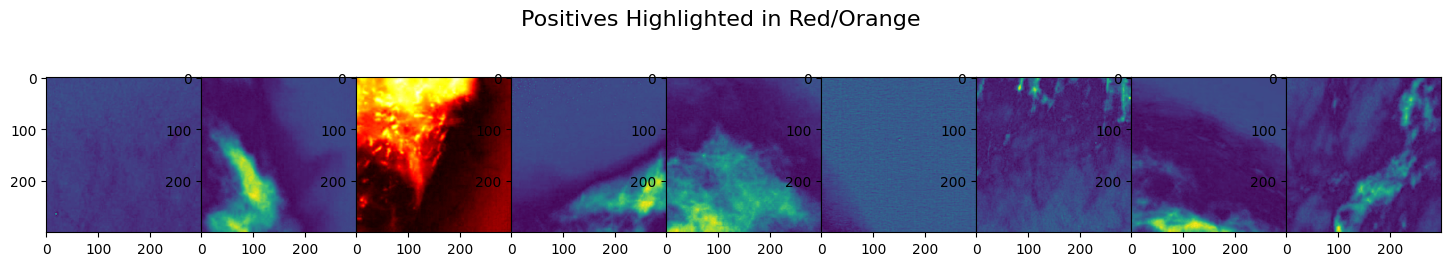

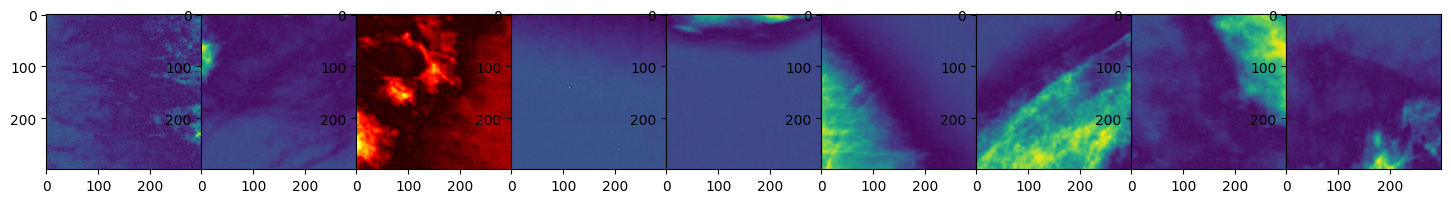

In [22]:
fig, ax = plt.subplots(1, 9, figsize=[18, 3])
fig2, ax2 = plt.subplots(1, 9, figsize=[18, 3])
fig.suptitle("Positives Highlighted in Red/Orange", fontsize=16)

for i in range(9):
    tmp = plt.imread(traindf.iloc[i, 0])
    tmp = tmp[:, :, 0]
    tmp2 = y_train[i].astype("int")
    ax[i].imshow(tmp) if tmp2 == 0 else ax[i].imshow(tmp, cmap="hot")
    fig.subplots_adjust(wspace=0, hspace=0)

for i in range(9):
    tmp = plt.imread(testdf.iloc[i, 0])
    tmp = tmp[:, :, 0]
    tmp2 = y_test[i].astype("int")
    ax2[i].imshow(tmp) if tmp2 == 0 else ax2[i].imshow(tmp, "hot")
    fig2.subplots_adjust(wspace=0, hspace=0)

## Data Generators

The data processed in the previous steps is finally encapsulated into generators to feed it into the model during training, and testing. An ```ImageDataGenerator``` object is first defined to preprocess images by rescaling their pixel values. Each pixel is normalised into the range [0, 255] by being divided by 255. This is known to improve the model's training efficiency, and performance.

In [23]:
random.seed(1234)

In [24]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

The training generator yields batches of preprocessed training images, and their corresponding labels from the ```traindf``` DataFrame. This feeds the model during training.

In [25]:
train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=None,
    x_col="file",
    y_col="label",
    class_mode="binary",
    color_mode="rgb",
    target_size=(299, 299),
    shuffle=True,
    batch_size=8,
    subset="training",
)

Found 55885 validated image filenames belonging to 2 classes.


A similar generator is made for the testing set.

In [26]:
test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col="file",
    y_col="label",
    class_mode="binary",
    color_mode="rgb",
    target_size=(299, 299),
    batch_size=8,
    shuffle=False,
)

Found 15364 validated image filenames belonging to 2 classes.


# ViT Model

The ViT model is trained slightly differently, owing to the fact that it utilised a PyTorch backend rather than TensorFlow through the HuggingFace ```transformers``` library. A base model is selected, and fine-tuned on the same dataset as the other models are. A seed is first set for the model training to be deterministic, and stay the same across multiple runs.

In [27]:
set_seed(42)

Firstly, the dataset is converted into a HuggingFace dataset.

In [28]:
train_dataset = Dataset.from_pandas(traindf[['file', 'label']])
test_dataset = Dataset.from_pandas(testdf[['file', 'label']])

A ViT image processor is then used to load the pre-trained transformer.

In [29]:
processor = ViTImageProcessor.from_pretrained('facebook/deit-tiny-patch16-224')

Data augmentation is performed on the training, and testing sets in order to help the model generalise better.

In [30]:
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

def transform(example_batch):
    images = [augment(Image.open(f).convert("RGB")) for f in example_batch["file"]]
    inputs = processor(images, return_tensors="pt")
    inputs["labels"] = [int(lbl) for lbl in example_batch["label"]]
    return inputs

prepared_train_ds = train_dataset.with_transform(transform)
prepared_test_ds = test_dataset.with_transform(transform)

A collator is defined to produce batches of data.

In [31]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch])
    }

A metric computing function is also defined.

In [32]:
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

The model is then defined for training.

In [33]:
labels_list = ["Negative", "Positive"]
model = ViTForImageClassification.from_pretrained(
    'facebook/deit-tiny-patch16-224',
    num_labels=len(labels_list),
    id2label={str(i): c for i, c in enumerate(labels_list)},
    label2id={c: str(i) for i, c in enumerate(labels_list)},
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The trainer, with all the parameters for training the model, is defined, including the previously defined functions.

In [34]:
training_args = TrainingArguments(
    output_dir="./models/vit-base-breast",
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    dataloader_num_workers=4,
    num_train_epochs=5,
    fp16=True,
    save_steps=100,
    gradient_accumulation_steps=4,
    eval_steps=100,
    logging_steps=10,
    learning_rate=5e-5,
    warmup_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_test_ds,
    tokenizer=processor,
)

/tmp/ipykernel_13160/2023647509.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training, and evaluation commences.

In [35]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate(prepared_test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.142200,0.119708,0.956587
2,0.099300,0.140361,0.955611
3,0.094400,0.104474,0.965439
4,0.069900,0.099345,0.970190
5,0.090400,0.088385,0.973314


***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1298525999GF
  train_loss               =       0.1164
  train_runtime            =   0:16:54.25
  train_samples_per_second =      275.498
  train_steps_per_second   =        8.612


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9729
  eval_loss               =     0.0869
  eval_runtime            = 0:00:20.77
  eval_samples_per_second =    739.418
  eval_steps_per_second   =     92.451


## Evaluating the Models

In [36]:
vit_model_tokenizer = ViTImageProcessor.from_pretrained("./models/vit-base-breast")
vit_model = ViTForImageClassification.from_pretrained("./models/vit-base-breast")

In [37]:
reset_keras()

This section evaluates the previously trained models using standard metrics like accuracy, and loss on the training, and validation sets. In the following cell, these metrics are extracted into variables for later use from the performance of the model across different epochs during training.

Predictions are made on the test set are made in order to generate a final classification report, and confusion matrix.

In [38]:
test_generator.reset()
vit_predictions = trainer.predict(prepared_test_ds)

The previously-made predictions, and actual values are gathered, and fed into ```scikit-learn``` to generate the confusion matrix.

In [39]:
vit_predictions = np.argmax(vit_predictions.predictions, axis=1)
vit_act=y_test.astype('int')
vit_cm = confusion_matrix(vit_act, vit_predictions)

The results are then plotted using ```seaborn```.

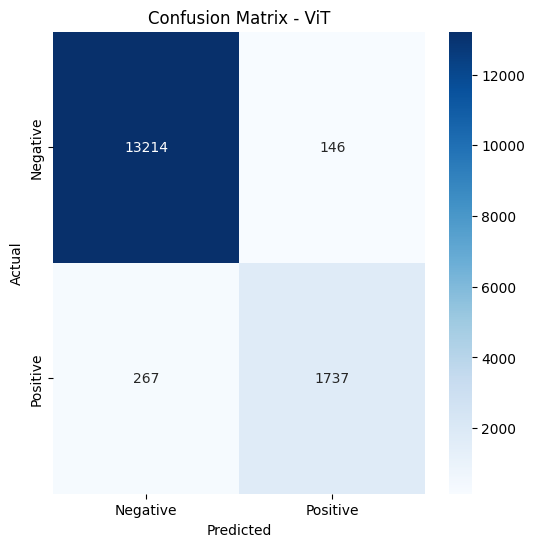

In [50]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    vit_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_list, yticklabels=labels_list
)
plt.title("Confusion Matrix - ViT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The same values are used to generate the final classification report.

In [47]:
vit_report_dict = classification_report(vit_act, vit_predictions, target_names=["Negative", "Positive"], output_dict=True)
vit_df = pd.DataFrame(vit_report_dict).transpose()
vit_df.style.background_gradient(cmap="Blues").format("{:.2f}")

,precision,recall,f1-score,support
Negative,0.98,0.99,0.98,13360.00
Positive,0.92,0.87,0.89,2004.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.95,0.93,0.94,15364.00
weighted avg,0.97,0.97,0.97,15364.00


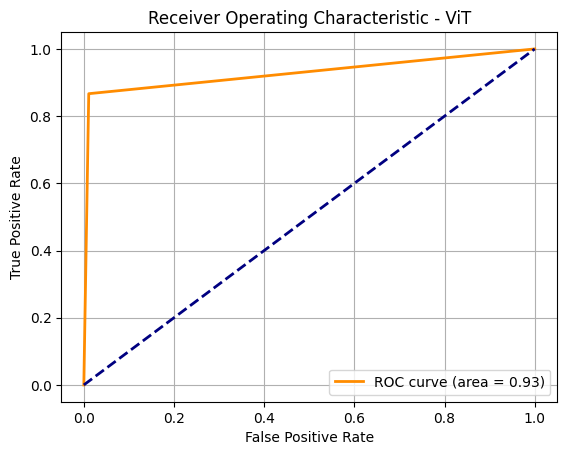

In [48]:
fpr, tpr, _ = roc_curve(vit_act, vit_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ViT')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model Explanation

This final section touches upon XAI or explainable AI, by implementing _Grad-CAM_ through the ```tf-explain``` module. This provides a visual indication of the parts of the image that influenced the classification made of the model, explaining the results achieved. This is done for the first ten images within the testing set, but can easily be done for any other image as well. The following function accepts a path to an image, the model used, and it's final layer, and returns the explained version of the image, and the classification result.

In the above plots, warmer colours indicate higher influence on the model's predicted class, and cooler colours the opposite. The target layer within the ViT is first extracted.

In [56]:
target_layer = vit_model.vit.encoder.layer[-1].output

The images are then rendered in the form of a plot.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.043137256..1.1411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686275..1.4058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..1.4137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0647058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764706..1.4607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764706..1.4333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4647

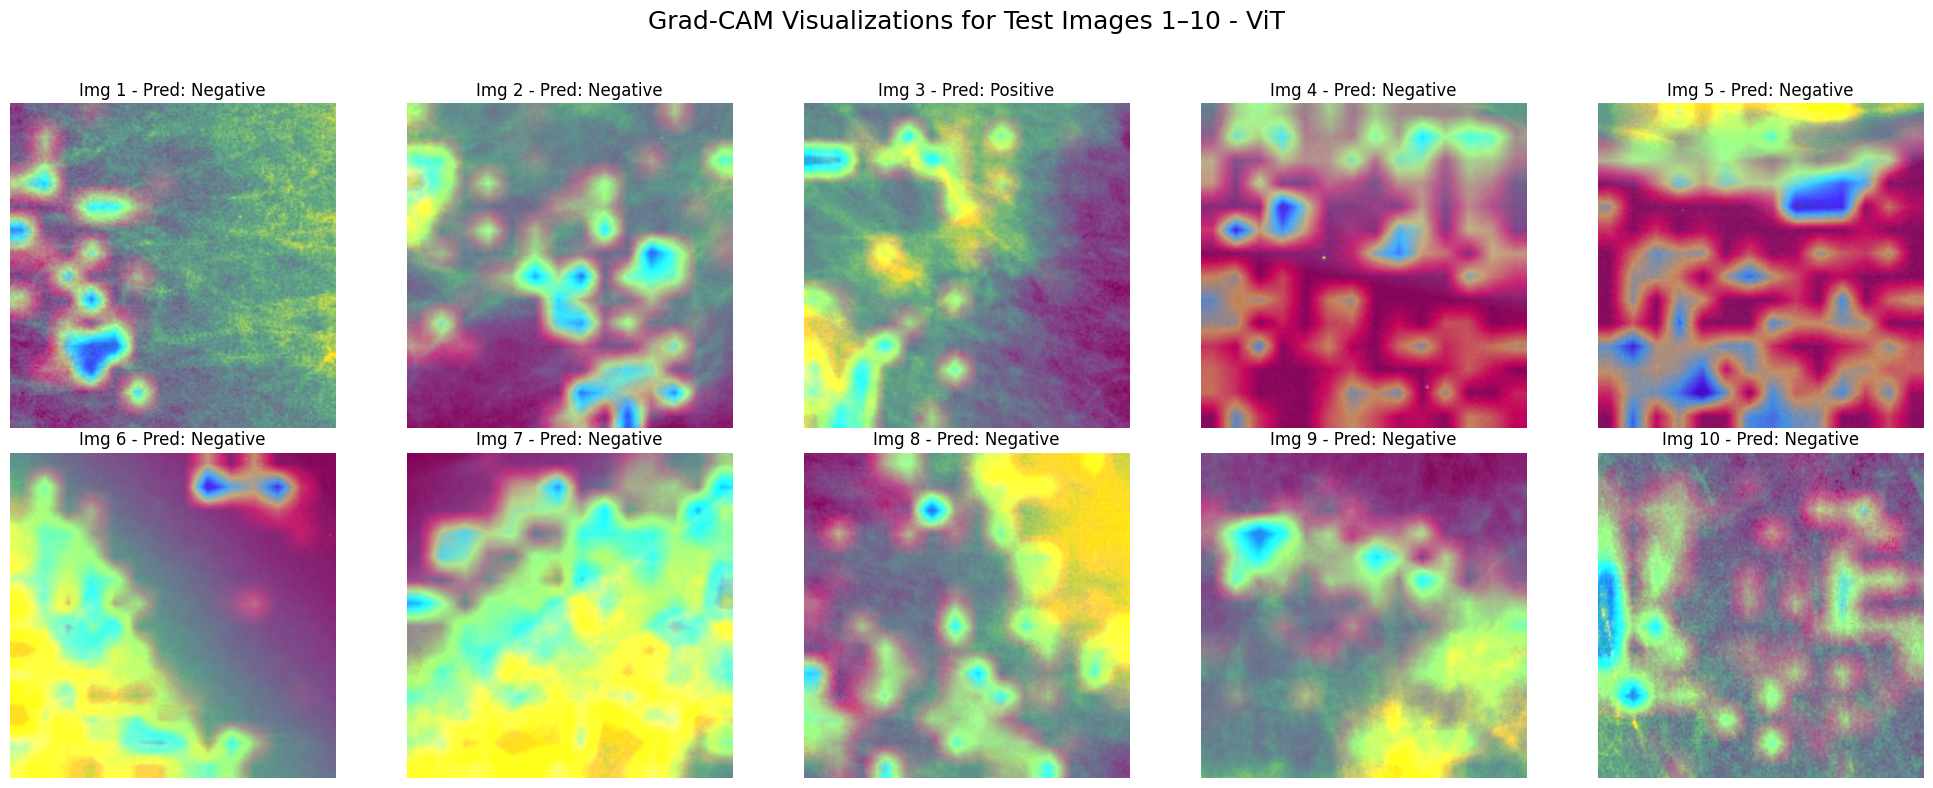

In [57]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Grad-CAM Visualizations for Test Images 1–10 - ViT", fontsize=18)

for i in range(10):
    img_path = testdf.iloc[i]["file"]

    vit_model.eval()
    img = Image.open(img_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt")

    activations, gradients = {}, {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    handle_fwd = target_layer.register_forward_hook(forward_hook)
    handle_bwd = target_layer.register_backward_hook(backward_hook)

    outputs = vit_model(**inputs)
    pred_class = outputs.logits.argmax(dim=1).item()

    one_hot = torch.zeros_like(outputs.logits)
    one_hot[0, pred_class] = 1
    outputs.logits.backward(gradient=one_hot)

    grads = gradients["value"]
    acts = activations["value"]
    weights = grads.mean(dim=1)
    cam = (acts * weights.unsqueeze(1)).sum(dim=-1)

    cam = cam[0, 1:]
    side = int(cam.shape[0]**0.5)
    cam = cam.reshape(side, side).cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    img_np = np.array(img)
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * 0.5 + np.float32(img_np) / 255

    handle_fwd.remove()
    handle_bwd.remove()

    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.imshow(overlay)
    ax.axis("off")
    ax.set_title(f"Img {i+1} - Pred: {labels_list[pred_class]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()